In [1]:
# Load packages
suppressMessages(library(saqgetr))
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openxlsx))
suppressMessages(library(plyr))

suppressMessages(library(openair))
suppressMessages(library(gridExtra))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

load("data/data_AQ.rda")
load("data/meteorology.rda")

# Lockdown dates

In [4]:
periods <- list(
    # lockdown
    lockdown = as.numeric(ymd("2020-03-14")),
    #end.lockdown = as.numeric(ymd_hms("2020-04-28 00:00:00")),

    # poslockdown
    fases = as.numeric(ymd("2020-05-01")),
    normalidad = as.numeric(ymd("2020-06-21")),

    # New lockdown
    new.lockdown = as.numeric(ymd("2020-10-25"))
)

## Load Data

In [5]:
aq <- data_AQ[data_AQ$site == "es1580a", ] %>%
            filter(variable == "no2") %>%
            timeAverage(avg.time = "day")
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == "es1580a", ]

df <- merge(aq, mto,
              by = "date", all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -site)

head(df)

,date,value,ws,wd,atmos_pres,tmed,prec,tmin,tmax,presMax,presMin,RH,solar.radiation
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013-01-01,14.91667,8.3500,286.6196,1019.650,11.6,5.5,10.6,12.6,1019.6,1007.3,88.11917,78.56742
2,2013-01-02,46.75000,5.7750,334.4606,1031.162,11.2,0.7,9.8,12.5,1028.7,1019.6,86.44662,60.13676
3,2013-01-03,38.66667,4.9500,104.8580,1037.925,10.8,0.0,8.4,13.2,1030.6,1028.7,85.19767,48.69664
4,2013-01-04,46.62500,3.5375,124.9080,1037.975,11.4,0.0,8.0,14.7,1031.2,1029.6,83.13043,81.60853
5,2013-01-05,38.29167,3.0000,124.7949,1035.957,9.1,0.0,7.7,10.5,1029.7,1027.6,89.72875,89.20845
6,2013-01-06,21.25000,3.6750,109.5865,1031.825,10.5,0.0,8.0,13.0,1027.7,1022.4,90.22318,86.77671


In [6]:
train <-  which(df$date < ymd("2020-01-01"))

In [7]:
df.data <- df %>%
        select(-date) %>% scale() %>%
        data.frame()
time <- df$date

In [8]:
df.apply <- apply(df.data, 2, function(cl) {
    dcomp <- decompose(ts(cl, frequency = 365))
    
    cl - dcomp$seasonal
}) %>% data.frame()

## Analysis

In [9]:
anly.data <- df.apply

In [10]:
fit.th <- lm(value ~., data = anly.data, subset=train)

In [11]:
y.th <- predict(fit.th, newdata = anly.data)

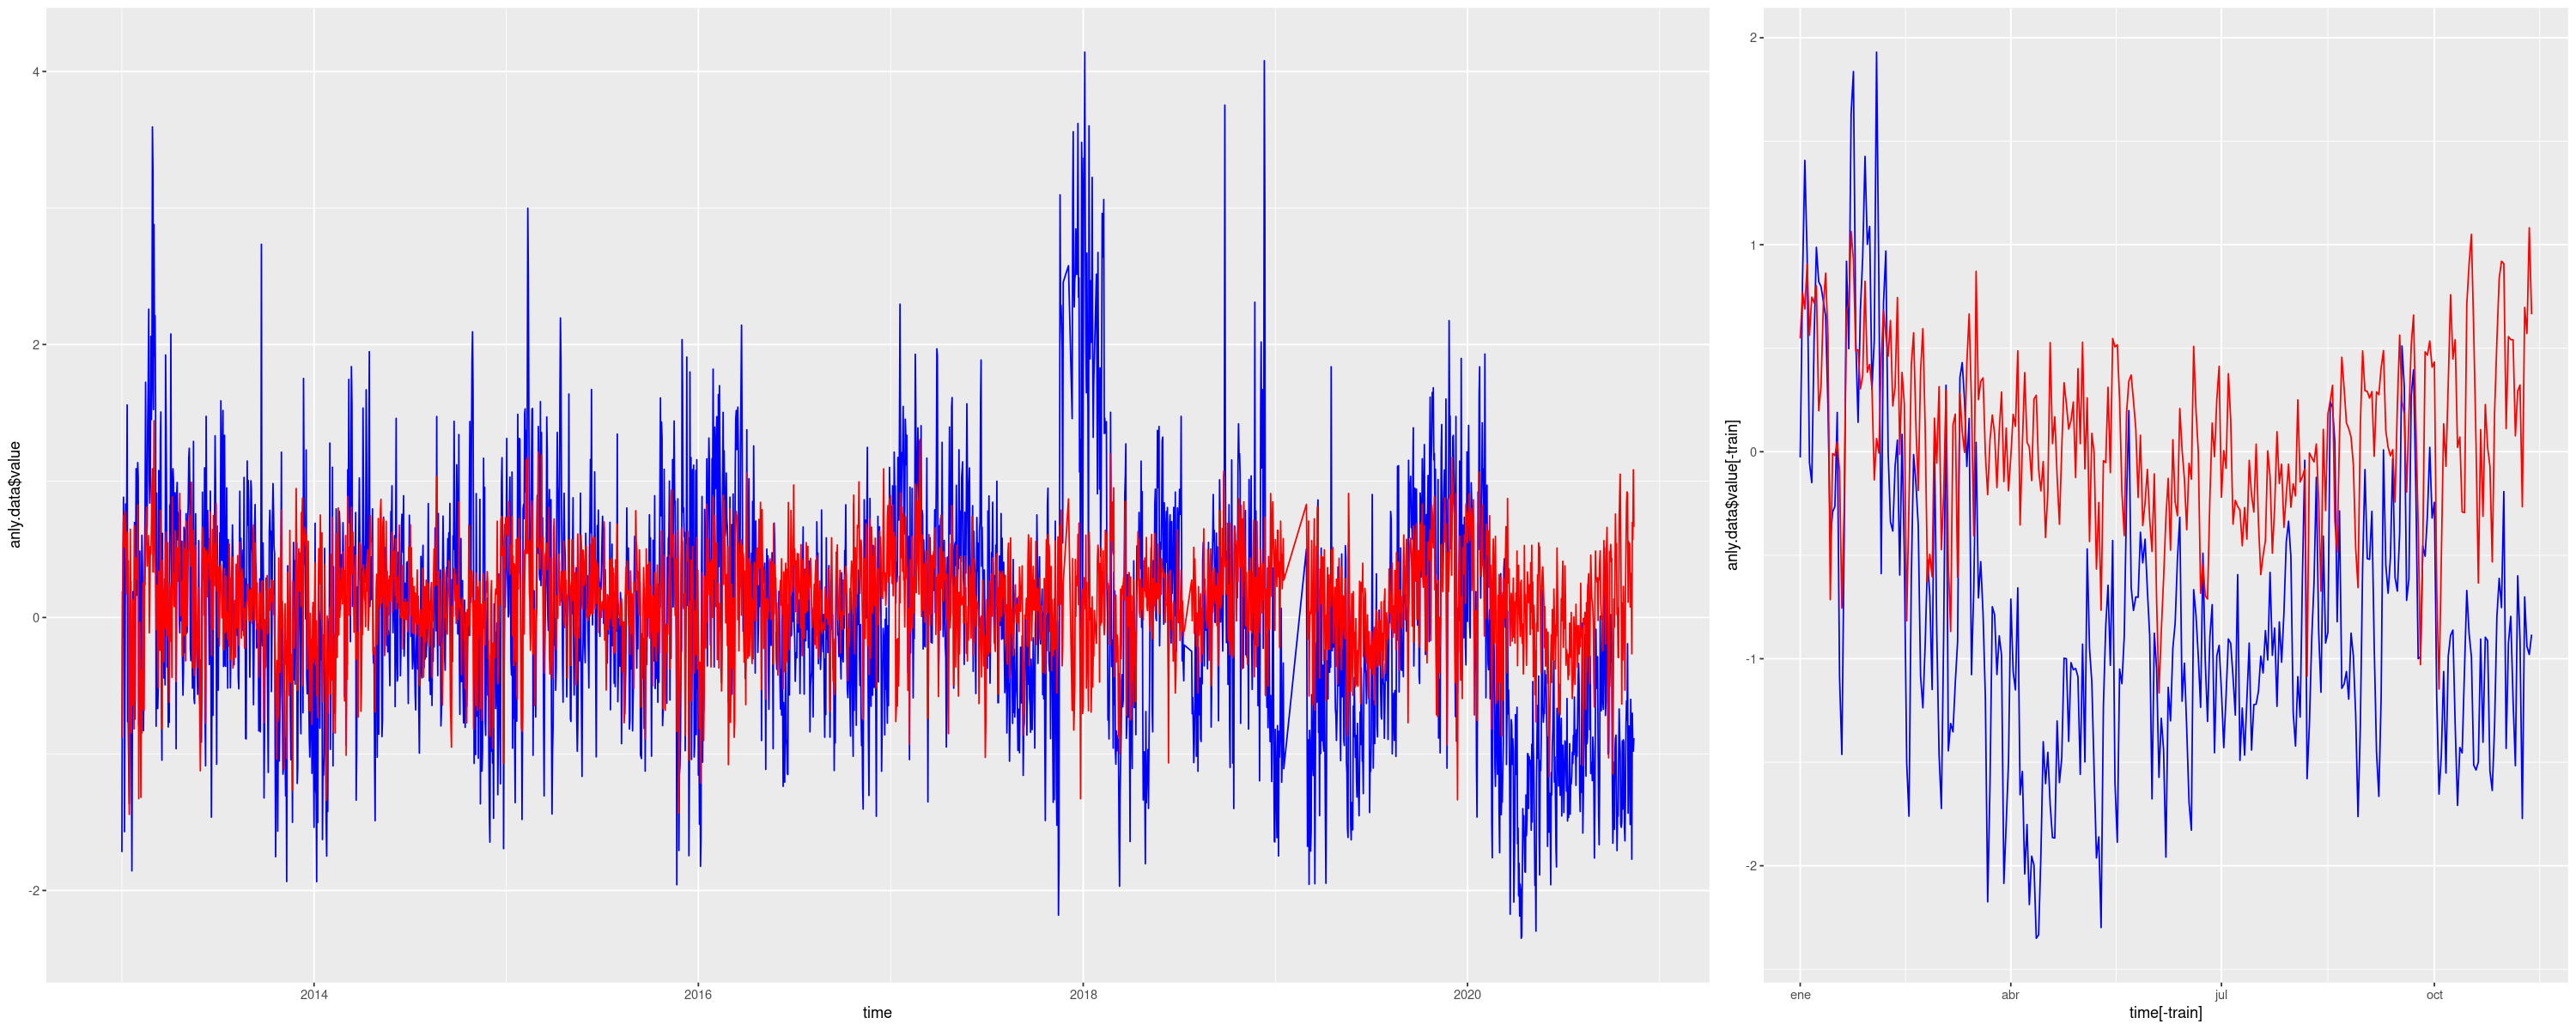

In [12]:
all.series <- ggplot() +
                geom_line(aes(x = time, y = anly.data$value), color="blue") +
                geom_line(aes(x = time, y = y.th), color="red")
last.series <- ggplot() +
                geom_line(aes(x = time[-train], y = anly.data$value[-train]), color="blue") +
                geom_line(aes(x = time[-train], y = y.th[-train]), color="red")

grid.arrange(all.series, last.series, nrow = 1, widths = c(2, 1))

## Using `segmented` package

In [13]:
suppressMessages(library(segmented))

var <- data.frame(y = (anly.data$value[-train] - y.th[-train] ),
                  x = as.numeric(time[-train]))

my.seg.1 <- segmented(lm(y ~ x, data=var), 
                      seg.Z = ~ x,
                      psi = list(x = periods)
                     )

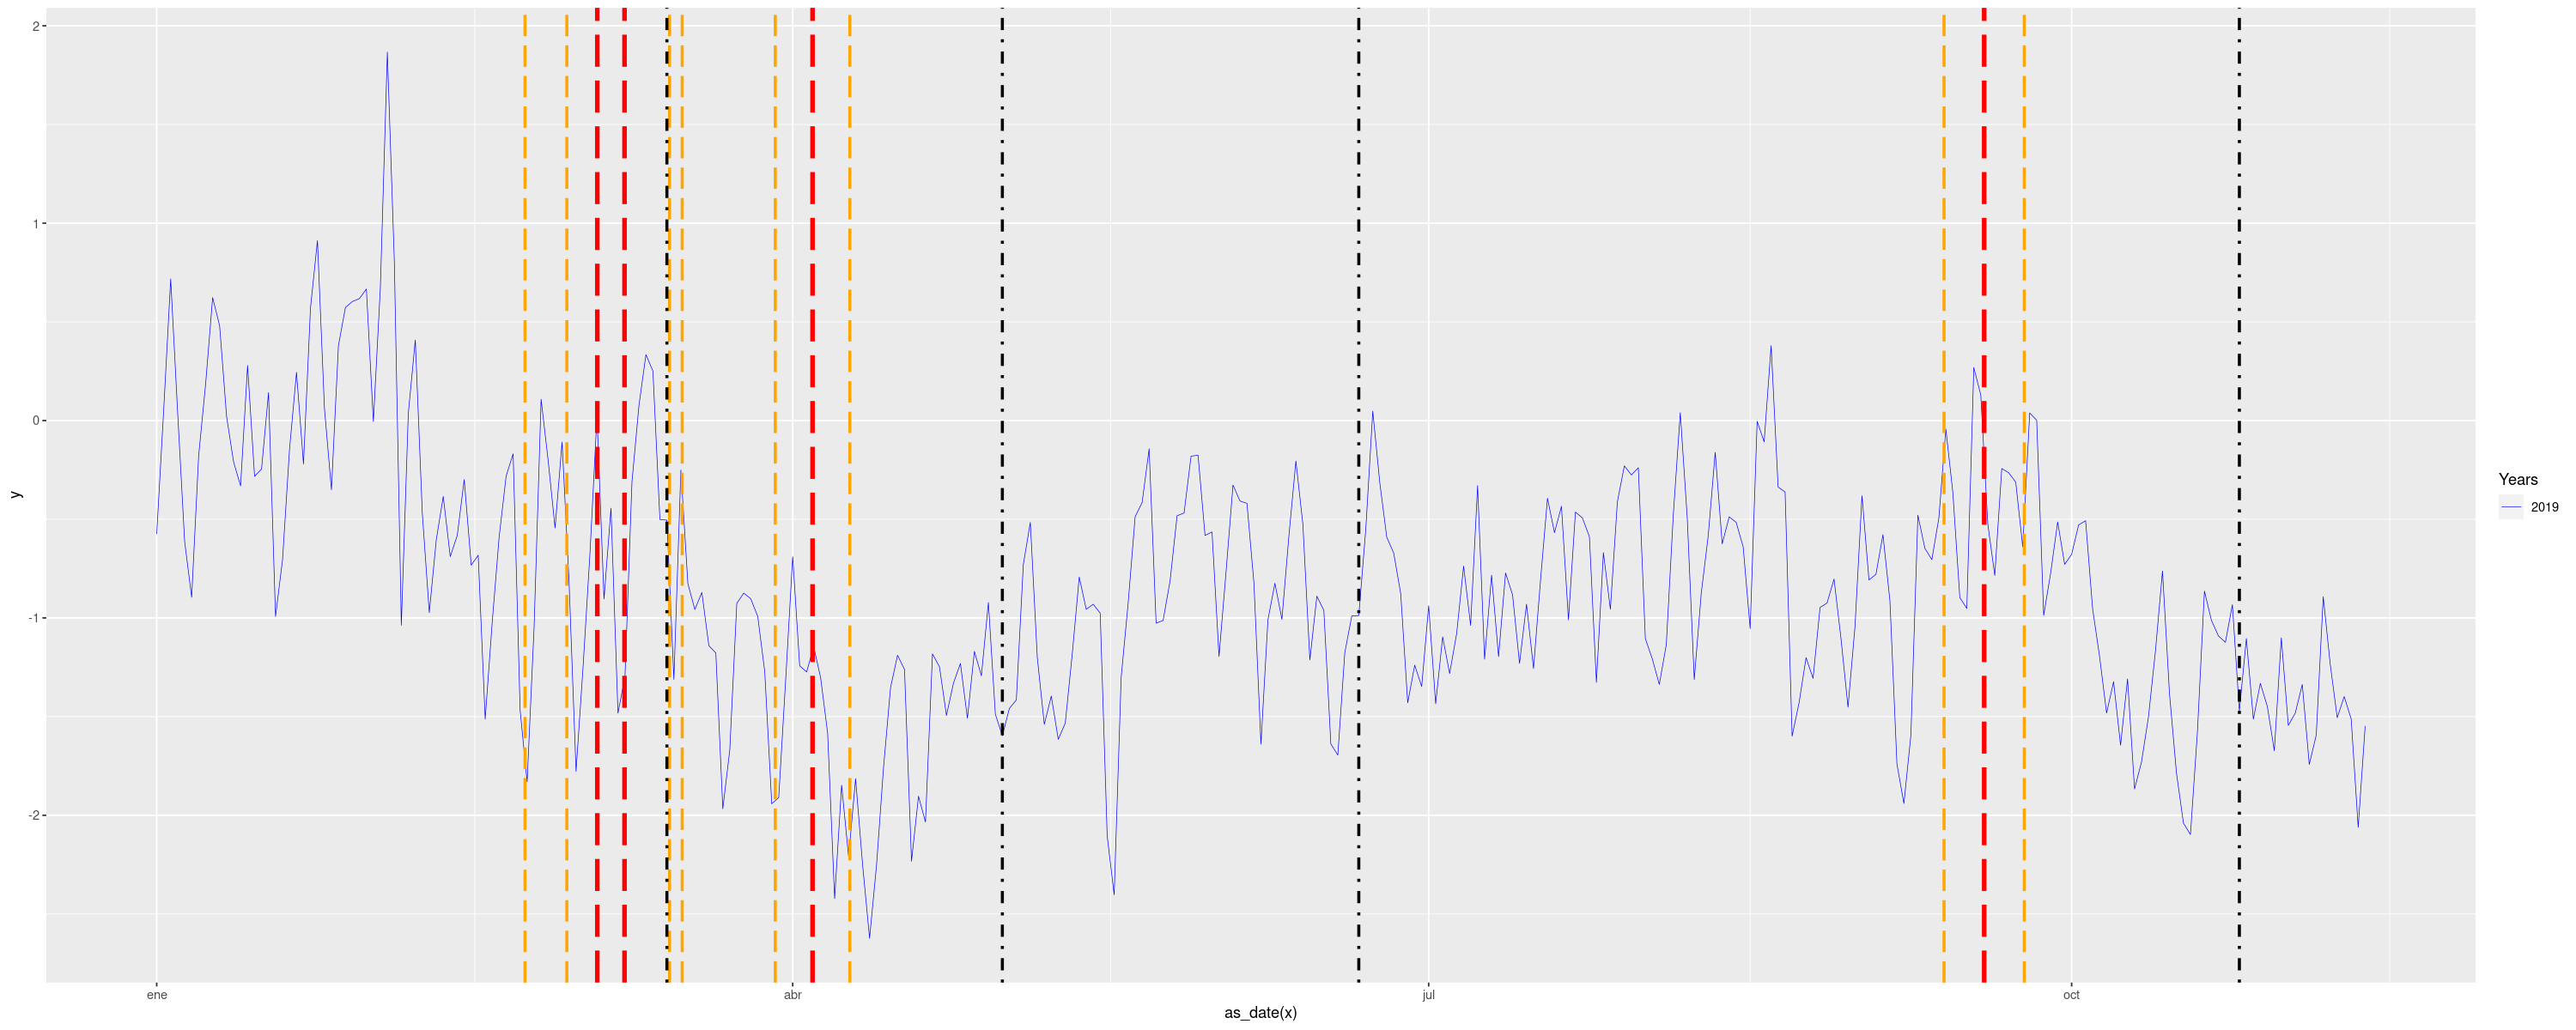

In [14]:
plot <- ggplot(data=var, aes(x=as_date(x)))+ 
    scale_color_manual(name = "Years", 
                       values = c("2019" = "blue"))

plot <- plot + geom_line(aes(y=y, color="2019"), size=0.2)

if (length(my.seg.1$psi) != 0) {
    for (k in 1:(nrow(my.seg.1$psi))) {
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."], 
                                  linetype=5, color = "red", size=1.5)
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."] - my.seg.1$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."] + my.seg.1$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
    }
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot

In [15]:
as_date(my.seg.1$psi[, "Est."])
as_date(my.seg.1$psi[, "Initial"])

psi1.x       psi2.x       psi3.x       psi4.x 
"2020-03-04" "2020-03-07" "2020-04-03" "2020-09-18"

psi1.x       psi2.x       psi3.x       psi4.x 
"2020-03-14" "2020-05-01" "2020-06-21" "2020-10-25"

## Using `strucchange` package

In [16]:
suppressMessages(library(strucchange))

my.other.seg.1 <- breakpoints(y ~ x+1, 
                              h = 0.15, 
                              breaks = 4,
                              data = var)
new.breaks.1 <- as_datetime(my.other.seg.1$breakpoints)

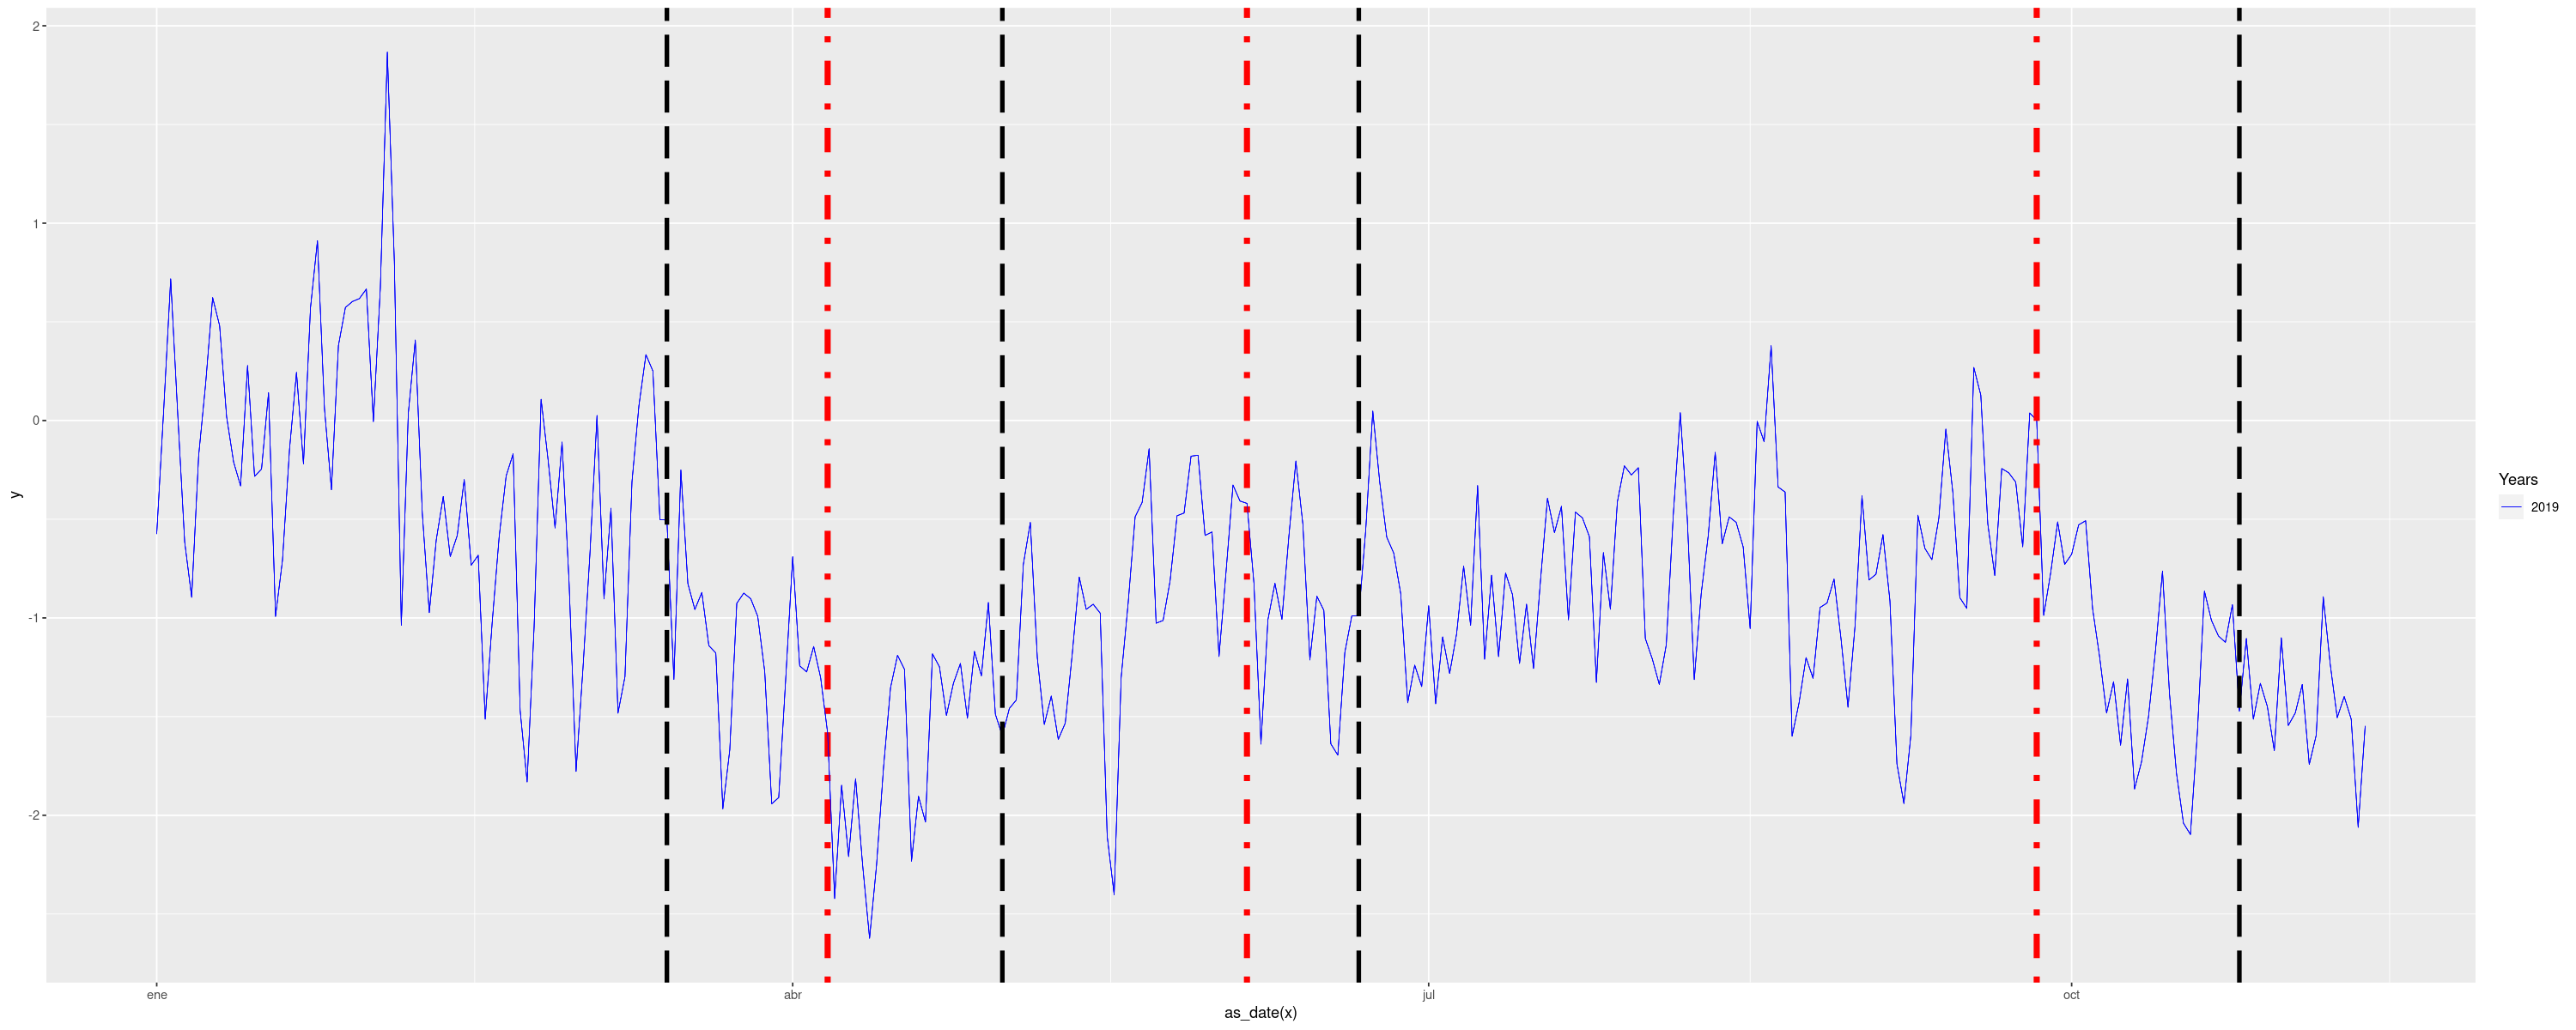

In [17]:
plot <- ggplot(data=var, aes(x=as_date(x))) + 
        scale_color_manual(name = "Years", values = c("2019" = "blue"))
for (k in 1:(length(new.breaks.1))) {
    plot <- plot + geom_line(aes(y=y, color="2019"), size=0.2)
    plot <- plot + geom_vline(xintercept = var$x[new.breaks.1[k]], 
                              linetype=4, color = "red", size=2)
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=5, color = "black", size=1.5)
}

plot 

In [18]:
time[-train][new.breaks.1]

[1] "2020-04-06" "2020-06-05" "2020-09-26"

## Relative Change

In [19]:
data.prd.raw <- list()
data.prd.model <- list()

new.periods <- c(as.numeric(ymd("2020-01-01")), periods, as.numeric(max(time)))

for (i in 2:length(new.periods)) {
    data.prd.raw[[names(periods)[i-1]]] <- mean(anly.data$value[which(time < new.periods[i] &
                                                       time > new.periods[i-1])])
    data.prd.model[[names(periods)[i-1]]] <- mean(y.th[which(time < new.periods[i] &
                                                       time > new.periods[i-1])])
}

In [20]:
names(data.prd.model)[5] <- "end.year"
names(data.prd.raw)[5] <- "end.year"

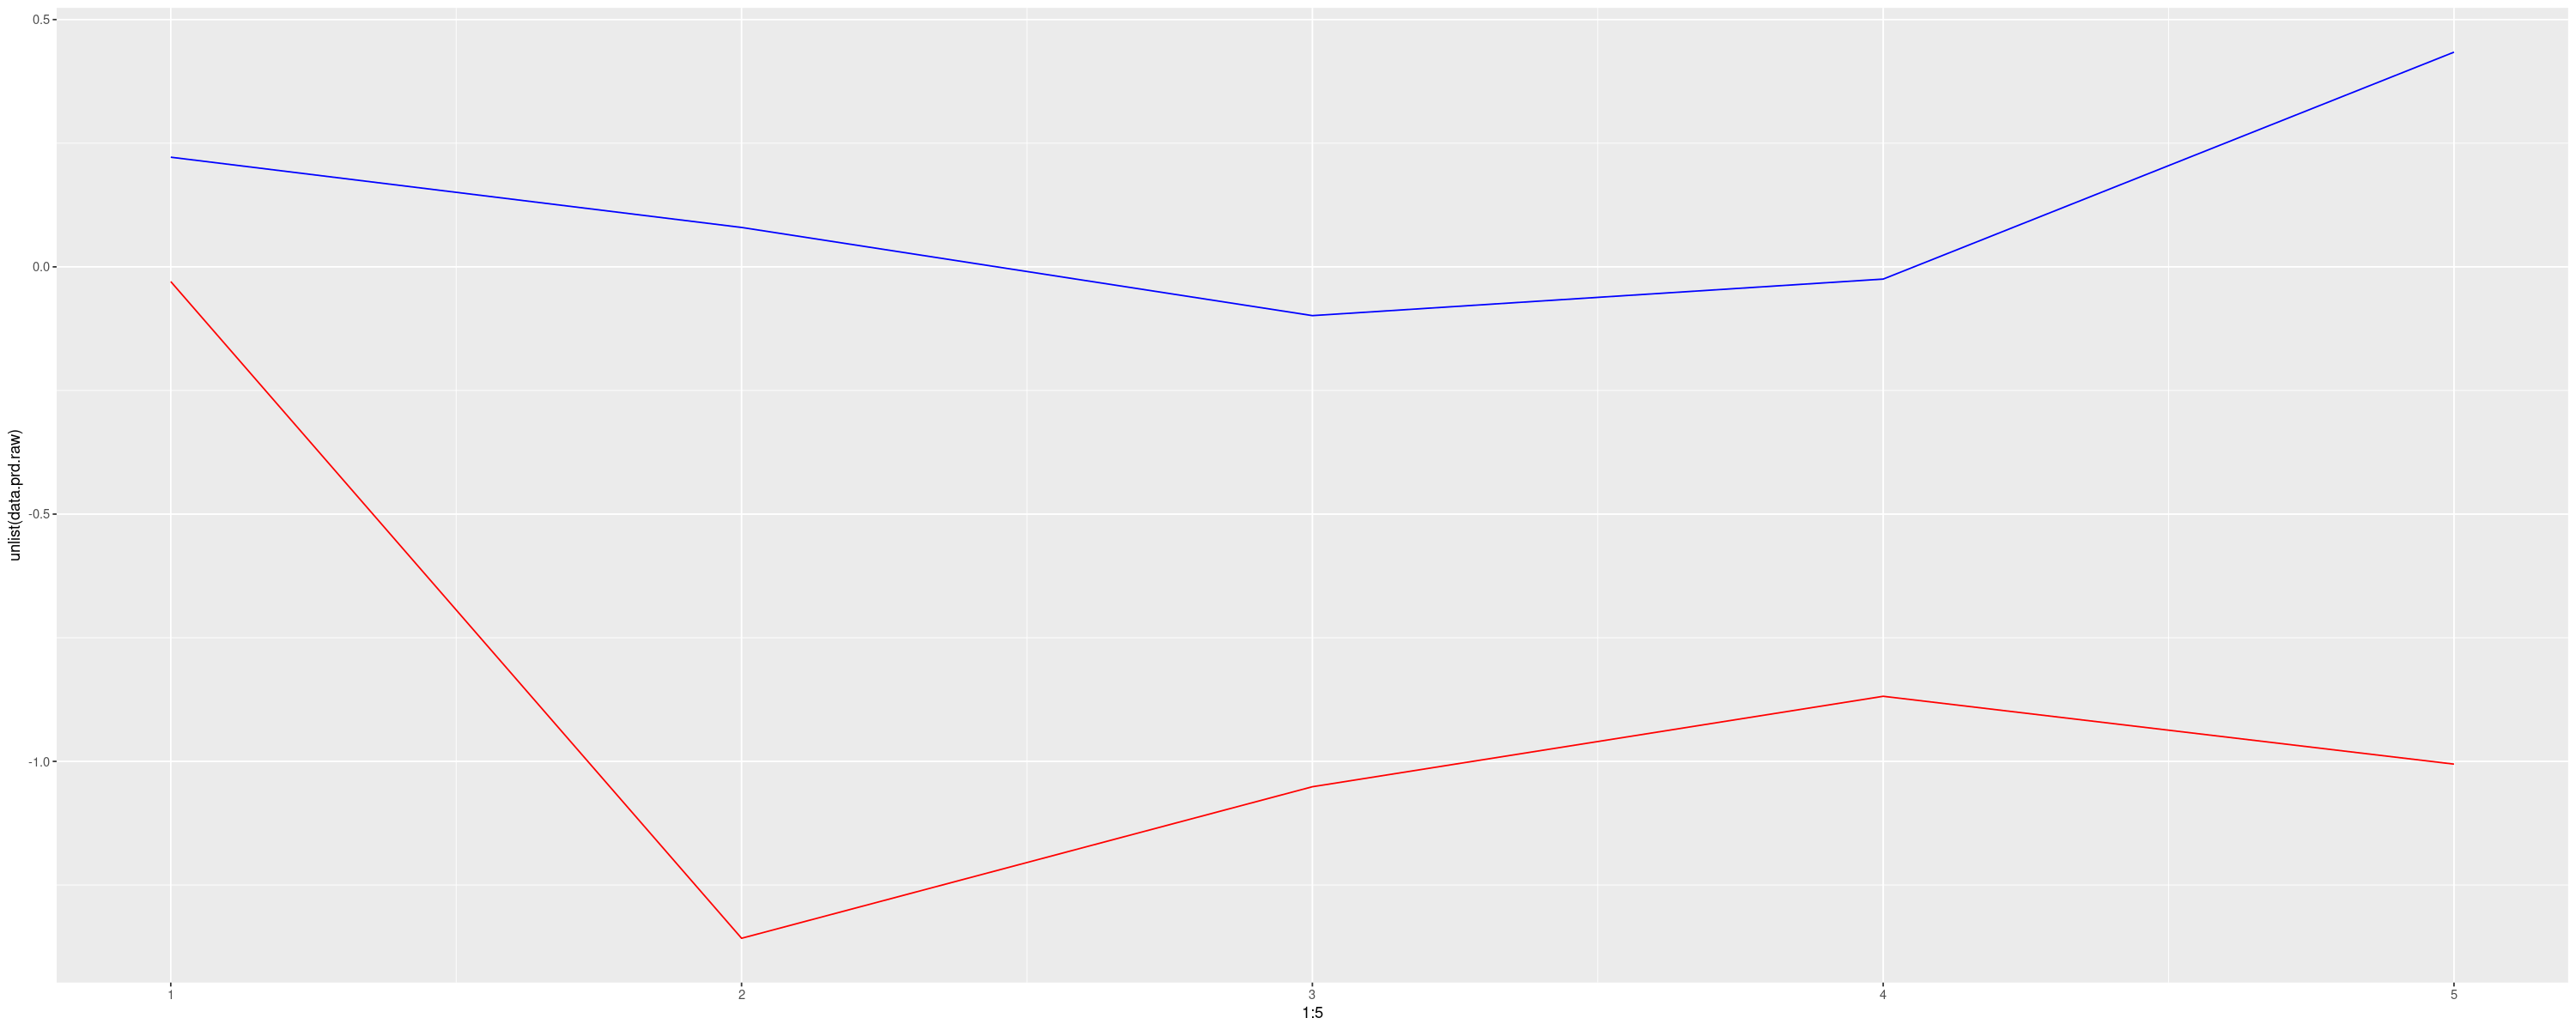

In [21]:
ggplot() +
    geom_line(aes(x=1:5, y=unlist(data.prd.raw)), color="red") +
    geom_line(aes(x=1:5, y=unlist(data.prd.model)), color="blue")

In [22]:
change <- list()

for (nm in names(data.prd.model)) {
    x <- unlist(data.prd.raw)
    y <- unlist(data.prd.model)
    f.x.y <- min(c(abs(y)))
    #f.x.y <- data.prd.model[[nm]]
    change[[nm]] <- ((data.prd.raw[[nm]] - data.prd.model[[nm]]) 
                     / f.x.y)
}

change

$lockdown
[1] -10.17314

$fases
[1] -58.14216

$normalidad
[1] -38.53649

$new.lockdown
[1] -34.12716

$end.year
[1] -58.23871